# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= False,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


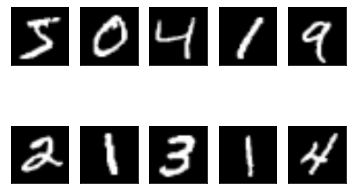

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True) # dataset generator를 생성한다.

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images
nz = 100 # size of z latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # conv layer의 가중치는 std = 0.02인 정규분포로 셋팅
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # Batchnorm layer의 가중치는 mu = 1, std = 0.02인 정규분포 셋팅
        nn.init.constant_(m.bias.data, 0) # 편향에 대해서는 0으로 셋팅팅

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z = (100, 1, 1) -> (1024, 4, 4)
            #ConvTranspose는 Conv와 반대로 이미지의 크기를 upsampling하는 과정이다. 쉽게 말하면 픽셀에 대하여 확대하는 것이다.
            #ConvTranspose 대신에 Upsampling을 하면 되지 않을까 ? 라는 생각이 들지만 Upsampling은 단순이 이미지를 확장시키는 interpolation인 non-trainable layer 이지만
            #ConvTranspose는 이미지를 확대하는것 뿐만 아니라 trainable layer로 학습을 통해 보다 feature representation이 가능하다.
            nn.ConvTranspose2d(nz, ngf*16, kernel_size = 4,stride = 1,padding = 0, bias = False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            # (1024, 4, 4) -> (512, 8, 8)
            nn.ConvTranspose2d(ngf*16, ngf*8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            ## (512, 8, 8) -> (256, 16, 16)
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride= 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (256, 16, 16) -> (128, 32, 32)
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (128, 32, 32) -> (1, 64, 64)
            nn.ConvTranspose2d(ngf*2, nc, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [ ]:
import torchsummary

torchsummary.summary(netG, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           2,048
             Tanh-14            [-1, 1,

### 판별자 클래스

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (1, 64, 64) -> (128, 32, 32)
            nn.Conv2d(nc, ndf*2, kernel_size=4, stride =2, padding=1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            # (128, 32, 32) -> (256, 16, 16)
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),
            # (256, 16, 16) -> (512, 8, 8)
            nn.Conv2d(ndf*4, ndf * 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            # (512, 8, 8) -> (1024, 4, 4)
            nn.Conv2d(ndf*8, ndf * 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace = True),
            # (1024, 4, 4) -> (1, 1, 1)
            nn.Conv2d(ndf * 16 , 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.Sigmoid()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
import torchsummary

torchsummary.summary(netD, input_size=(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           2,048
         LeakyReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 256, 16, 16]         524,288
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
            Conv2d-6            [-1, 512, 8, 8]       2,097,152
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-10           [-1, 1024, 4, 4]           2,048
        LeakyReLU-11           [-1, 1024, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]          16,384
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 11,032,064
Trainable para

## Loss Function & Optimizer

In [ ]:
# 손실함수
criterion = nn.BCELoss()



# optimizer hyperparameters
learning_rate = 0.0002
beta1 = 0.5

#noise 

real_label = 1.
fake_label = 0.
fixed_z_ = torch.randn(64, nz, 1, 1, device = device)


# optimizers
optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas=(beta1, 0.999))

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      # Discriminator 의 목표 : maximize log(D(x)) + log(1-D(G(z)))
      # Discriminator 초기화
      netD.zero_grad()
      # 데이터 
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # 실제 데이터에 대한 label

      output = netD(real_cpu).view(-1)  # 실제 데이터에 대하여 연산을 하여 loss를 구한다. 

      errD_real = criterion(output, label) # 실제 데이터에 대하여 gradients를 계산하여 backward 한다.
      errD_real.backward() 
      D_x = output.mean().item()

      # latent vector로 fake image를 생성한다.
      noise = torch.randn(b_size, nz, 1, 1, device=device)

      fake = netG(noise)
      label.fill_(fake_label) # 가짜 데이터의 label
      
      # # Generator로 생성한 fake 데이터에 대하여 Discriminator가 학습을 한 후 fake 데이터에 대한 loss를 구한다.
      output = netD(fake.detach()).view(-1)
      errD_fake = criterion(output, label)
      errD_fake.backward() # fake 데이터에 대하여 gradients를 계산하여 backward 한다.
      D_G_z1 = output.mean().item()

      # 실제 데이터와 fake 데이터에 대한 loss 값, 즉 log(D(x)) + log(D(G(z))) 를 의미한다.
      errD = errD_real + errD_fake

      optimizerD.step()
      
      # Generator의 목표 : maximize log(D(G(z))), 기존 방법에는 minimize log(1-DG(z))였지만 학습 초기에 충분한 gradient를 제공하지 못해 log(D(G(z)))를 최대화 하는 방향으로 학습을 하였다.
      netG.zero_grad()
      label.fill_(real_label) # 따라서 real label을 이용하여 Generator의 loss를 계산 및 gradients를 구하여 backward 한다.
      output = netD(fake).view(-1)

      errG = criterion(output, label)
      errG.backward()
      D_G_z2 = output.mean().item()
      optimizerG.step()

        # 학습 경과 출력
      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch, num_epochs, i, len(dataloader),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/5][0/469]	Loss_D: 1.9515	Loss_G: 5.3106	D(x): 0.3657	D(G(z)): 0.4046 / 0.0077
[0/5][50/469]	Loss_D: 0.0001	Loss_G: 49.8656	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.0000	Loss_G: 49.7044	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.0000	Loss_G: 49.7697	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][200/469]	Loss_D: 0.0000	Loss_G: 49.9212	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][250/469]	Loss_D: 0.0001	Loss_G: 49.7826	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][300/469]	Loss_D: 0.0000	Loss_G: 49.6026	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][350/469]	Loss_D: 0.0000	Loss_G: 49.4311	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/469]	Loss_D: 0.0000	Loss_G: 49.5661	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/469]	Loss_D: 0.0000	Loss_G: 49.5202	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/469]	Loss_D: 0.0000	Loss_G: 49.3355	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][50/469]	Loss_D: 0.0000	Loss_G: 59.8419	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000

KeyboardInterrupt: ignored

In [ ]:
with torch.no_grad() :
  fake = netG(fixed_z_).detach().cpu()

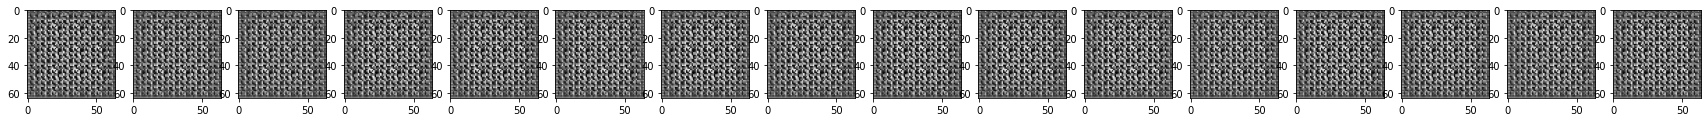

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for i in range(16):
    image = fake[i,0].numpy()
    image *= 255.
    ax[i].imshow(image, cmap='gray')
plt.show()

- 논문의 방법대로 Generator의 output channels를 100 - > 1028 -> 512 -> 256 -> 128 -> 1 으로 학습을 진행하였더니 위의 결과를 볼 수 있듯이 Discriminator가 학습이 전혀 되지 않고, Generator의 loss도 높은 model collapse가 일어나 size를 줄여서 새로 학습을 진행하겠다.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z = (100, 1, 1) -> (512, 4, 4)
            nn.ConvTranspose2d(nz, ngf*8, kernel_size = 4,stride = 1,padding = 0, bias = False), #ConvTranspose는 Conv와 반대로 이미지의 크기를 upsampling하는 과정이다. 쉽게 말하면 픽셀에 대하여 확대하는 것이다.
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # (512, 4, 4) -> (256, 8, 8)
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            ## (256, 8, 8) -> (128, 16, 16)
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride= 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (128, 16, 16) -> (64, 32, 32)
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # (64, 32, 32) -> (1, 64, 64)
            nn.ConvTranspose2d(ngf, nc, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
import torchsummary

torchsummary.summary(netG, input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # (1, 64, 64) -> (64, 32, 32)
            nn.Conv2d(nc, ndf, kernel_size=4, stride =2, padding=1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            # (64, 32, 32) -> (128, 16, 16)
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),
            # (128, 16, 16) -> (256, 8, 8)
            nn.Conv2d(ndf*2, ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),
            # (256, 8, 8) -> (512, 4, 4)
            nn.Conv2d(ndf*4, ndf * 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            # (512, 4, 4) -> (1, 1, 1)
            nn.Conv2d(ndf * 8 , 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.Sigmoid()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
import torchsummary

torchsummary.summary(netD, input_size=(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,763,520
Trainable param

In [ ]:
# 손실함수
criterion = nn.BCELoss().to(device)



# optimizer hyperparameters
learning_rate = 0.0002
beta1 = 0.5

#noise 

real_label = 1.
fake_label = 0.



# optimizers
optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas=(beta1, 0.999))

In [ ]:
num_epochs = 5
generate_image = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      # Discriminator 의 목표 : maximize log(D(x)) + log(1-D(G(z)))
      # Discriminator 초기화
      netD.zero_grad()
      # 데이터 
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # 실제 데이터에 대한 label

      output = netD(real_cpu).view(-1)  # 실제 데이터에 대하여 연산을 하여 loss를 구한다. 

      errD_real = criterion(output, label) # 실제 데이터에 대하여 gradients를 계산하여 backward 한다.
      errD_real.backward() 
      D_x = output.mean().item()

      # latent vector로 fake image를 생성한다.
      noise = torch.randn(b_size, nz, 1, 1, device=device)

      fake = netG(noise)
      label.fill_(fake_label) # 가짜 데이터의 label
      
      # # Generator로 생성한 fake 데이터에 대하여 Discriminator가 학습을 한 후 fake 데이터에 대한 loss를 구한다.
      output = netD(fake.detach()).view(-1)
      errD_fake = criterion(output, label)
      errD_fake.backward() # fake 데이터에 대하여 gradients를 계산하여 backward 한다.
      D_G_z1 = output.mean().item()

      # 실제 데이터와 fake 데이터에 대한 loss 값, 즉 log(D(x)) + log(D(G(z))) 를 의미한다.
      errD = errD_real + errD_fake

      optimizerD.step()
      
      # Generator의 목표 : maximize log(D(G(z))), 기존 방법에는 minimize log(1-DG(z))였지만 학습 초기에 충분한 gradient를 제공하지 못해 log(D(G(z)))를 최대화 하는 방향으로 학습을 하였다.
      netG.zero_grad()
      label.fill_(real_label) # 따라서 real label을 이용하여 Generator의 loss를 계산 및 gradients를 구하여 backward 한다.
      output = netD(fake).view(-1)

      errG = criterion(output, label)
      errG.backward()
      D_G_z2 = output.mean().item()
      optimizerG.step()

        # 학습 경과 출력
      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch, num_epochs, i, len(dataloader),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    

    # Generator가 생성한 image
    fixed_z_ = torch.randn(64, nz, 1, 1, device = device)
    with torch.no_grad() :
      fake = netG(fixed_z_).detach().cpu()
    generate_image.append(fake)

[0/5][0/469]	Loss_D: 1.5548	Loss_G: 2.3884	D(x): 0.3887	D(G(z)): 0.3102 / 0.1229
[0/5][50/469]	Loss_D: 0.0533	Loss_G: 25.8938	D(x): 0.9568	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.6390	Loss_G: 5.9496	D(x): 0.6528	D(G(z)): 0.0024 / 0.0101
[0/5][150/469]	Loss_D: 0.2080	Loss_G: 5.1905	D(x): 0.9555	D(G(z)): 0.1197 / 0.0099
[0/5][200/469]	Loss_D: 0.2944	Loss_G: 4.6562	D(x): 0.9232	D(G(z)): 0.1644 / 0.0162
[0/5][250/469]	Loss_D: 0.1095	Loss_G: 4.3772	D(x): 0.9356	D(G(z)): 0.0250 / 0.0181
[0/5][300/469]	Loss_D: 1.0422	Loss_G: 2.3086	D(x): 0.4607	D(G(z)): 0.0317 / 0.2030
[0/5][350/469]	Loss_D: 0.1626	Loss_G: 4.2326	D(x): 0.9401	D(G(z)): 0.0899 / 0.0220
[0/5][400/469]	Loss_D: 0.1924	Loss_G: 2.9972	D(x): 0.8895	D(G(z)): 0.0617 / 0.0661
[0/5][450/469]	Loss_D: 0.7446	Loss_G: 1.5185	D(x): 0.6216	D(G(z)): 0.1624 / 0.2709
[1/5][0/469]	Loss_D: 0.5206	Loss_G: 3.5803	D(x): 0.8951	D(G(z)): 0.2954 / 0.0441
[1/5][50/469]	Loss_D: 0.3002	Loss_G: 2.3940	D(x): 0.8611	D(G(z)): 0.1190 / 0.1182
[1/5][100

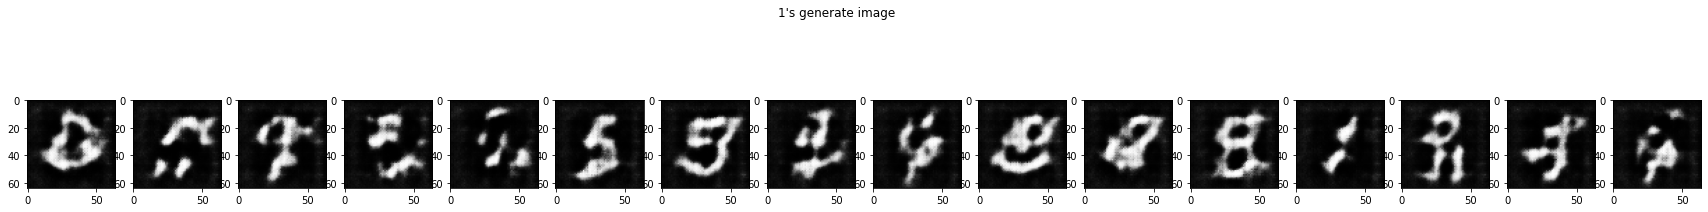

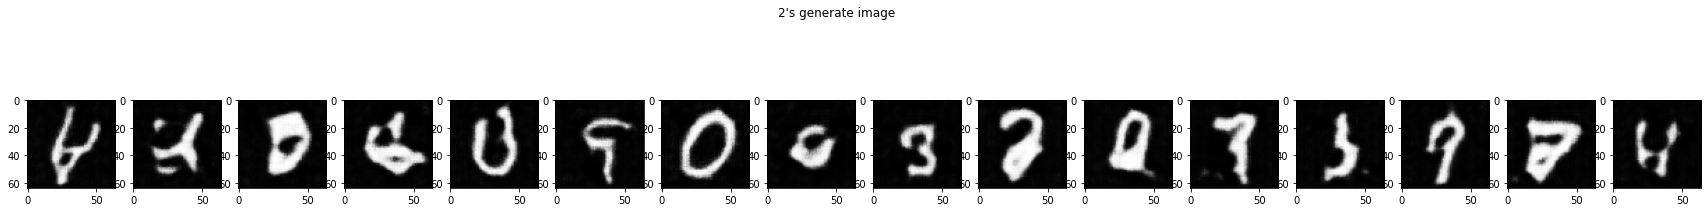

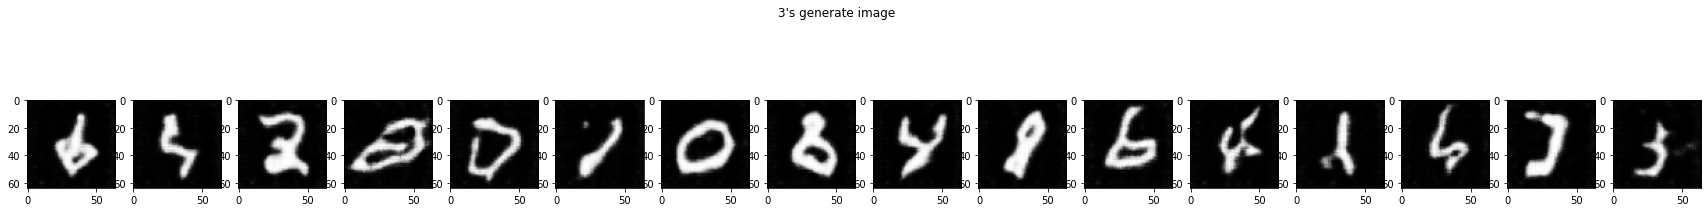

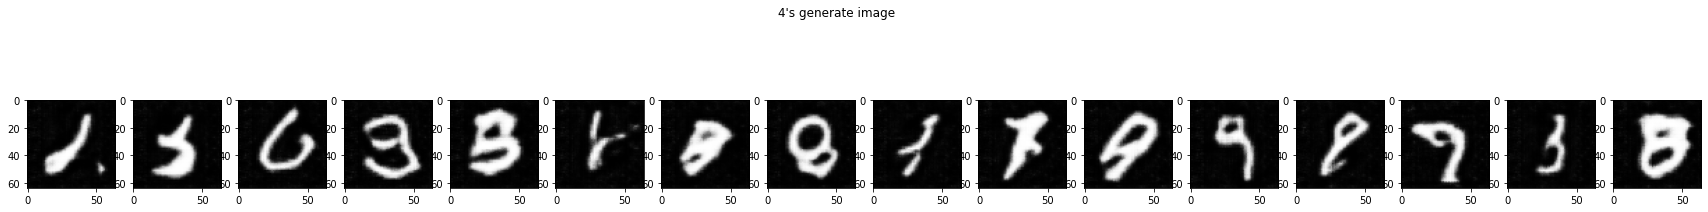

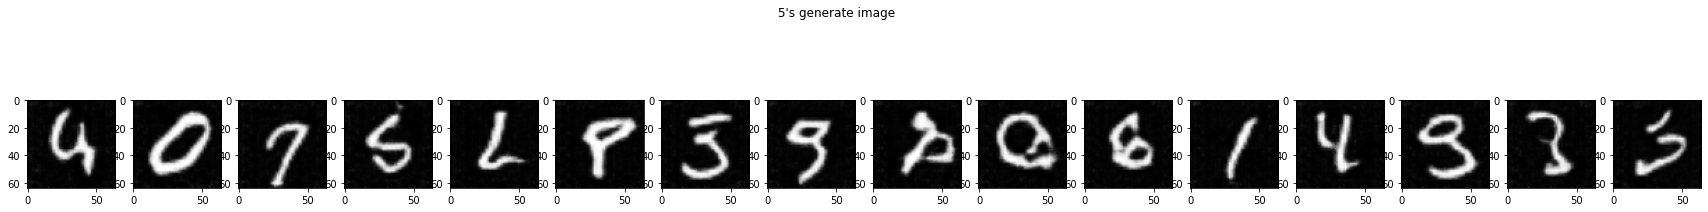

In [ ]:
for i in range(5) :
  fake = generate_image[i]
  fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))
  for j in range(16):
      image = fake[j,0].numpy()
      image *= 255.
      ax[j].imshow(image, cmap='gray')
  fig.suptitle(f"{i+1}'s generate image")

plt.show()

- 결과를 확인해 보면 5epochs만 학습했을 뿐인데 왼손으로 쓴 듯한 이미지가 생성되는것을 확인할 수 있다.